## TabNet 

### Parameters

+ n_d: width decision predition layer[8,64], 
+ n_a:width attention [8,64], 
+ n_steps: steps in the architecture [3,10], 
+ gamma: coefficiente for feature reuse [1,2], close to 1 least corrlated default 1.3,
+ n_independent [1,5]: number of independent gated linear units, 2
+ n_shared [1,5], 2, 
+ epsilon=1e-15, 
+ momentum:0.01 to 0.4, default 0.02
+ lambda_sparse, seed, clip_value, verbose

In [25]:
# importing necessary libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

import os

#TabNet librariees
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

#https://www.kaggle.com/code/enigmak/tabnet-deep-neural-network-for-tabular-data


## Experiment forest Cover type dataset

In [ ]:
base_path = 'homeworks/data/project/gesture_phase/'

In [68]:
base_pah = 'homeworks/data/project/'
df_forest = pd.read_csv(base_pah + 'forest_cover.csv')

In [66]:
df_forest.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [69]:
df_forest = df_forest.drop('Id', axis=1)


In [70]:
df_forest = df_forest.dropna()

In [71]:
X=df_forest.drop('Cover_Type', axis=1)
y=df_forest['Cover_Type']

In [73]:
X = df_forest.values[:, :-1]
y_target = df_forest.values[:, -1]
# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the data
y = le.fit_transform(y_target)

In [75]:
## Transformacion en clases de tipo binaria para multitask
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories=[range(7)], sparse=False)
y = ohe.fit_transform(y.reshape(-1, 1))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [77]:
print(y.shape)

(15120, 7)


In [78]:
# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
X_standardized = scaler.fit_transform(X)

# Verificar la media y la varianza después de la estandarización
mean_standardized = np.mean(X_standardized, axis=0)
variance_standardized = np.var(X_standardized, axis=0)

In [79]:
## Split the dataset
# Dividir los datos en entrenamiento y el resto
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir el resto en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)


In [80]:
clf_multitask = TabNetMultiTaskClassifier(n_d=6, n_a=6,epsilon=0.01,n_steps=8,seed=42,verbose=1,)

# Entrenar el modelo multitarea
clf_multitask.fit(
    X_train=X_train,y_train= y_train,
    eval_set=[(X_val, y_val)],
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    eval_metric=["logloss"]
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63457 | val_0_logloss: 0.49469 |  0:00:02s
epoch 1  | loss: 0.40255 | val_0_logloss: 0.42379 |  0:00:03s
epoch 2  | loss: 0.36665 | val_0_logloss: 0.39469 |  0:00:05s
epoch 3  | loss: 0.3171  | val_0_logloss: 0.46618 |  0:00:07s
epoch 4  | loss: 0.30042 | val_0_logloss: 0.40922 |  0:00:09s
epoch 5  | loss: 0.29616 | val_0_logloss: 0.34264 |  0:00:10s
epoch 6  | loss: 0.28446 | val_0_logloss: 0.33446 |  0:00:12s
epoch 7  | loss: 0.26874 | val_0_logloss: 0.25277 |  0:00:14s
epoch 8  | loss: 0.26042 | val_0_logloss: 0.32813 |  0:00:16s
epoch 9  | loss: 0.25613 | val_0_logloss: 0.24473 |  0:00:18s
epoch 10 | loss: 0.25477 | val_0_logloss: 0.24237 |  0:00:19s
epoch 11 | loss: 0.25373 | val_0_logloss: 0.24914 |  0:00:21s
epoch 12 | loss: 0.2489  | val_0_logloss: 0.23739 |  0:00:23s
epoch 13 | loss: 0.24939 | val_0_logloss: 0.25259 |  0:00:24s
epoch 14 | loss: 0.25793 | val_0_logloss: 0.24484 |  0:00:26s
epoch 15 | loss: 0.25472 | val_0_logloss: 0.2398  |  0:00:28s
epoch 16

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


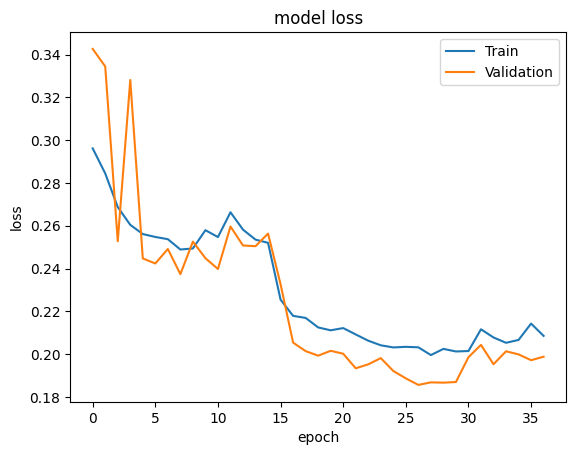

In [85]:
from matplotlib import pyplot as plt

plt.plot(clf_multitask.history['loss'][5:], label='Train')
plt.plot(clf_multitask.history['val_0_logloss'][5:], label='Validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_curve_covertype_tabnet.png')
plt.show()

## Experiments with Gesture Dataset

In [60]:
## Preprocessing
base_path = 'homeworks/data/project/gesture_phase/'
df = pd.read_csv(base_path + 'gesture_phase.csv')
X = df.values[:, :-1]
y_target = df.values[:, -1]
# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the data
y = le.fit_transform(y_target)

In [61]:


# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
X_standardized = scaler.fit_transform(X)

# Verificar la media y la varianza después de la estandarización
mean_standardized = np.mean(X_standardized, axis=0)
variance_standardized = np.var(X_standardized, axis=0)

In [62]:
## Transformacion en clases de tipo binaria para multitask
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories=[range(5)], sparse=False)
y = ohe.fit_transform(y.reshape(-1, 1))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [63]:
## Splitting the data

X_train_val, X_test, y_train_val, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

## Split into train and validation sets

# Paso 2: Dividir el 80% de entrenamiento + validación en 70% entrenamiento y 10% validación
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print(y_train.shape,X_train.shape)
print(y_val.shape,X_val.shape)
print(y_test.shape,X_test.shape)


(6910, 5) (6910, 32)
(988, 5) (988, 32)
(1975, 5) (1975, 32)


## Traning Classifier

In [64]:
clf_multitask = TabNetMultiTaskClassifier(n_d=6, n_a=6,epsilon=0.01,n_steps=8,seed=42,verbose=1,)

# Entrenar el modelo multitarea
clf_multitask.fit(
    X_train=X_train,y_train= y_train,
    eval_set=[(X_val, y_val)],
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    eval_metric=["logloss"]
)





/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53674 | val_0_logloss: 0.48137 |  0:00:00s
epoch 1  | loss: 0.46785 | val_0_logloss: 0.45572 |  0:00:01s
epoch 2  | loss: 0.4497  | val_0_logloss: 0.45384 |  0:00:02s
epoch 3  | loss: 0.44141 | val_0_logloss: 0.43927 |  0:00:03s
epoch 4  | loss: 0.43548 | val_0_logloss: 0.43468 |  0:00:04s
epoch 5  | loss: 0.43514 | val_0_logloss: 0.43291 |  0:00:05s
epoch 6  | loss: 0.43263 | val_0_logloss: 0.43261 |  0:00:06s
epoch 7  | loss: 0.42926 | val_0_logloss: 0.42669 |  0:00:07s
epoch 8  | loss: 0.42365 | val_0_logloss: 0.4294  |  0:00:08s
epoch 9  | loss: 0.42706 | val_0_logloss: 0.43006 |  0:00:09s
epoch 10 | loss: 0.42381 | val_0_logloss: 0.42962 |  0:00:10s
epoch 11 | loss: 0.4254  | val_0_logloss: 0.42681 |  0:00:11s
epoch 12 | loss: 0.4219  | val_0_logloss: 0.42536 |  0:00:12s
epoch 13 | loss: 0.42255 | val_0_logloss: 0.43308 |  0:00:12s
epoch 14 | loss: 0.41884 | val_0_logloss: 0.44534 |  0:00:13s
epoch 15 | loss: 0.41906 | val_0_logloss: 0.42119 |  0:00:14s
epoch 16

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


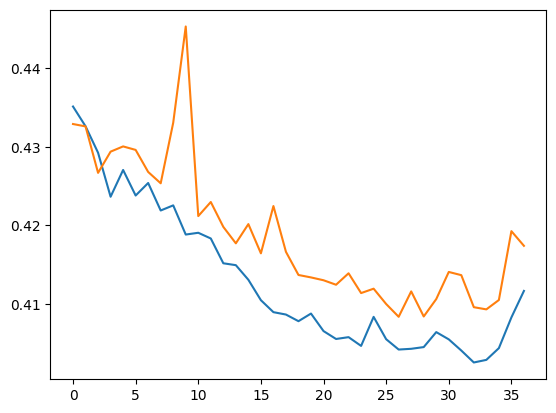

In [65]:
from matplotlib import pyplot as plt
#%matplotlib inline
#print(clf_multitask.history['loos'])
plt.plot(clf_multitask.history['loss'][5:])
plt.plot(clf_multitask.history['val_0_logloss'][5:])

plt.show()

In [68]:
# Realizar predicciones multitarea

#y_pred_multitask = clf_multitask.predict(X_test)
#print(y_pred_multitask[0])

# Obtener etiquetas verdaderas
#y_true = y_test

# Calcular exactitud
#accuracy = accuracy_score(y_true, y_pred_multitask)
#print(f"Exactitud: {accuracy:.4f}")

# Calcular matriz de confusión
#conf_matrix = confusion_matrix(y_true, y_pred_multitask)
#print("Matriz de Confusión:")
#print(conf_matrix)

# Calcular reporte de clasificación
#class_report = classification_report(y_true, y_pred_multitask)
#print("Reporte de Clasificación:")
#print(class_report)

# Calcular log loss
#log_loss_value = log_loss(y_true, probs)
#print(f"Pérdida de Log: {log_loss_value:.4f}")




['0.0' '1.0' '0.0' ... '0.0' '0.0' '0.0']


## Experiments with Shrutime


In [88]:
## Preprocessing
base_path = 'homeworks/data/project/'
df = pd.read_csv(base_path + 'shrutime_encoded.csv')
X = df.values[:, :-1]
y_target = df.values[:, -1]
# Initialize the LabelEncoder
le = LabelEncoder()
# Fit and transform the data
y = le.fit_transform(y_target)

In [92]:
## Data Standardization
# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
X_standardized = scaler.fit_transform(X)

# Verificar la media y la varianza después de la estandarización
mean_standardized = np.mean(X_standardized, axis=0)
variance_standardized = np.var(X_standardized, axis=0)

In [94]:
## Splitting the data

X_train_val, X_test, y_train_val, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

## Split into train and validation sets

# Paso 2: Dividir el 80% de entrenamiento + validación en 70% entrenamiento y 10% validación
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print(y_train.shape,X_train.shape)
print(y_val.shape,X_val.shape)
print(y_test.shape,X_test.shape)

(7000,) (7000, 13)
(1000,) (1000, 13)
(2000,) (2000, 13)


In [101]:
clf = TabNetClassifier(n_d=6, n_a=6,epsilon=0.01,n_steps=8,seed=42,verbose=1,)  #TabNetRegressor()
clf.fit(
  X_train, y_train,
  eval_set=[(X_val, y_val)],
   patience=10,
    batch_size=256,
    virtual_batch_size=128,
    eval_metric=["logloss"]
)
preds = clf.predict(X_test)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59866 | val_0_logloss: 0.47418 |  0:00:00s
epoch 1  | loss: 0.47193 | val_0_logloss: 0.47444 |  0:00:01s
epoch 2  | loss: 0.44447 | val_0_logloss: 0.44857 |  0:00:02s
epoch 3  | loss: 0.41925 | val_0_logloss: 0.36928 |  0:00:03s
epoch 4  | loss: 0.40727 | val_0_logloss: 0.37969 |  0:00:04s
epoch 5  | loss: 0.38251 | val_0_logloss: 0.35643 |  0:00:04s
epoch 6  | loss: 0.37855 | val_0_logloss: 0.3434  |  0:00:05s
epoch 7  | loss: 0.37958 | val_0_logloss: 0.3383  |  0:00:06s
epoch 8  | loss: 0.37099 | val_0_logloss: 0.33982 |  0:00:07s
epoch 9  | loss: 0.37424 | val_0_logloss: 0.35694 |  0:00:07s
epoch 10 | loss: 0.37252 | val_0_logloss: 0.35158 |  0:00:08s
epoch 11 | loss: 0.36677 | val_0_logloss: 0.34469 |  0:00:09s
epoch 12 | loss: 0.36289 | val_0_logloss: 0.3448  |  0:00:10s
epoch 13 | loss: 0.36351 | val_0_logloss: 0.36261 |  0:00:10s
epoch 14 | loss: 0.36686 | val_0_logloss: 0.34023 |  0:00:11s
epoch 15 | loss: 0.36277 | val_0_logloss: 0.35037 |  0:00:12s
epoch 16

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Optimizacion Bayesiana 
------
Aun no funciona

In [42]:
## Setting the space
space = {
    'feature_dim': hp.randint('feature_dim', 20, 61),  # Uniforme discreto entre 20 y 60
    'output_dim': hp.randint('output_dim', 20, 61),    # Uniforme discreto entre 20 y 60
    'n_steps': hp.randint('n_steps', 1, 9),             # Uniforme discreto entre 1 y 8
    'bn_epsilon': hp.uniform('bn_epsilon', np.exp(-5), np.exp(-1)),  # Uniforme entre e−5 y e−1
    'relaxation_factor': hp.uniform('relaxation_factor', 0.3, 2),    # Uniforme entre 0.3 y 2
    'batch_size': hp.choice('batch_size', [512, 1024, 2048, 4096, 8192])  # Elección uniforme de tamaños de lote
}

## optimize 
def objective(params):
    # Crear el modelo
    model = TabNetMultiTaskClassifier(
       output_dim=params['output_dim'],
       n_steps=params['n_steps'],
    epsilon=params['bn_epsilon'],
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], patience=10,batch_size=params['batch_size'],virtual_batch_size=128)
    
    # Predict
    preds = model.predict(X_val)
    # Probabilities predictions
    probs = model.predict_proba(X_val)

    loss = log_loss(y_val, probs)
    #score = evaluate_model(model, X_val, y_val)  # Evaluar el modelo en el conjunto de validación
    return {'loss': loss, 'status': STATUS_OK}


# Definir el objeto Trials para almacenar los resultados
trials = Trials()

# Ejecutar la optimización
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  # Algoritmo de optimización de `hyperopt`
    max_evals=10,     # Número máximo de evaluaciones
    trials=trials      # Objeto Trials para almacenar los resultados
)

print("Mejores parámetros encontrados:")
print(best)

epoch 0  | loss: 0.63068 | val_0_logloss: 0.57648 |  0:00:00s
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 1  | loss: 0.50447 | val_0_logloss: 0.47678 |  0:00:00s
epoch 2  | loss: 0.46473 | val_0_logloss: 0.45185 |  0:00:00s
epoch 3  | loss: 0.44648 | val_0_logloss: 0.44312 |  0:00:00s
epoch 4  | loss: 0.43775 | val_0_logloss: 0.43763 |  0:00:00s
epoch 5  | loss: 0.43069 | val_0_logloss: 0.43161 |  0:00:00s
epoch 6  | loss: 0.42702 | val_0_logloss: 0.42796 |  0:00:01s
epoch 7  | loss: 0.42302 | val_0_logloss: 0.4241  |  0:00:01s
epoch 8  | loss: 0.42008 | val_0_logloss: 0.42005 |  0:00:01s
epoch 9  | loss: 0.41759 | val_0_logloss: 0.41751 |  0:00:01s
epoch 10 | loss: 0.41415 | val_0_logloss: 0.41591 |  0:00:01s
epoch 11 | loss: 0.4123  | val_0_logloss: 0.415   |  0:00:01s
epoch 12 | loss: 0.41011 | val_0_logloss: 0.4133  |  0:00:01s
epoch 13 | loss: 0.4087  | val_0_logloss: 0.41333 |  0:00:02s
epoch 14 | loss: 0.40866 | val_0_logloss: 0.41185 |  0:00:02s
epoch 15 | loss: 0.4031  | val_0_logloss: 0.41073 |  0:00:02s
epoch 16 | loss: 0.40464 | val_0_logloss: 0.4115  |  0:00:02s
epoch 17

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)

job exception: Found array with dim 3. None expected <= 2.



  0%|          | 0/10 [00:06<?, ?trial/s, best loss=?]


ValueError: Found array with dim 3. None expected <= 2.

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")

job exception: unsupported operand type(s) for +: 'dict' and 'int'



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


TypeError: unsupported operand type(s) for +: 'dict' and 'int'